# This notebook allows to reproduce the figure of the paper with coarser tracer data


Note that pre-trained models with coarser tracer data are not provided. Experiments should be reproduced by the user before running this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
import os
import numpy as np
import sys
notebook_path = '/mydata/watres/quentin/WATRES'
sys.path.append('/mydata/watres/quentin/WATRES/')
from WATRES import *
from WATRES.visualization import *
import pandas as pd

def compute_nse(observed, simulated):
    """
    Calculate the Nash-Sutcliffe Efficiency (NSE).
    
    Parameters:
    observed (array-like): Array of observed values.
    simulated (array-like): Array of simulated values.
    
    Returns:
    float: NSE value.
    """
    observed = np.array(observed)
    simulated = np.array(simulated)
    
    # Calculate the mean of the observed data
    mean_observed = np.mean(observed)
    
    # Compute the numerator and denominator of the NSE formula
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - mean_observed) ** 2)
    
    # Compute NSE
    nse_value = 1 - (numerator / denominator)
    
    return nse_value

In [3]:
mode2stride = { '2_weeks': 24*7*2,
               '1_week': 24*7,
              'daily': 24,
               'hourly': 1}
sites = list(mode2stride.keys())

algos = ['SumSquares_noBERT2_bayesian3'] 

algo2name = {'SumSquares_noBERT2_bayesian3': 'WATRES'}
settings = []
years_training = 10
for site in sites:
    for seed in range(0,9):
        pathsite = f'/mydata/watres/quentin/code/TRANSPORT/data/Pully_small_storage/subsampling/{site}/'
        for algo in algos:
            site_name2save=site+'_noise_0.1_yearstrain_'+str(years_training)+'_'+str(seed)
            settings.append({
                'site': f'{site}_{seed}',
                'pathsite': pathsite,
                'algo': algo,
                'path_model': os.path.join(pathsite, 'save', f'save_BERT4TRANSIT_{site_name2save}_no_c_{algo}.pth.tar'),
                'path_results': os.path.join(pathsite, 'save', f'results_{site_name2save}.pkl')
            
                #'path_results': os.path.join(pathsite, 'save', f'results_BERT4TRANSIT_{site}_{seed}_no_c_{algo}.pkl')
            })


results = gather_results_all_sites(settings)

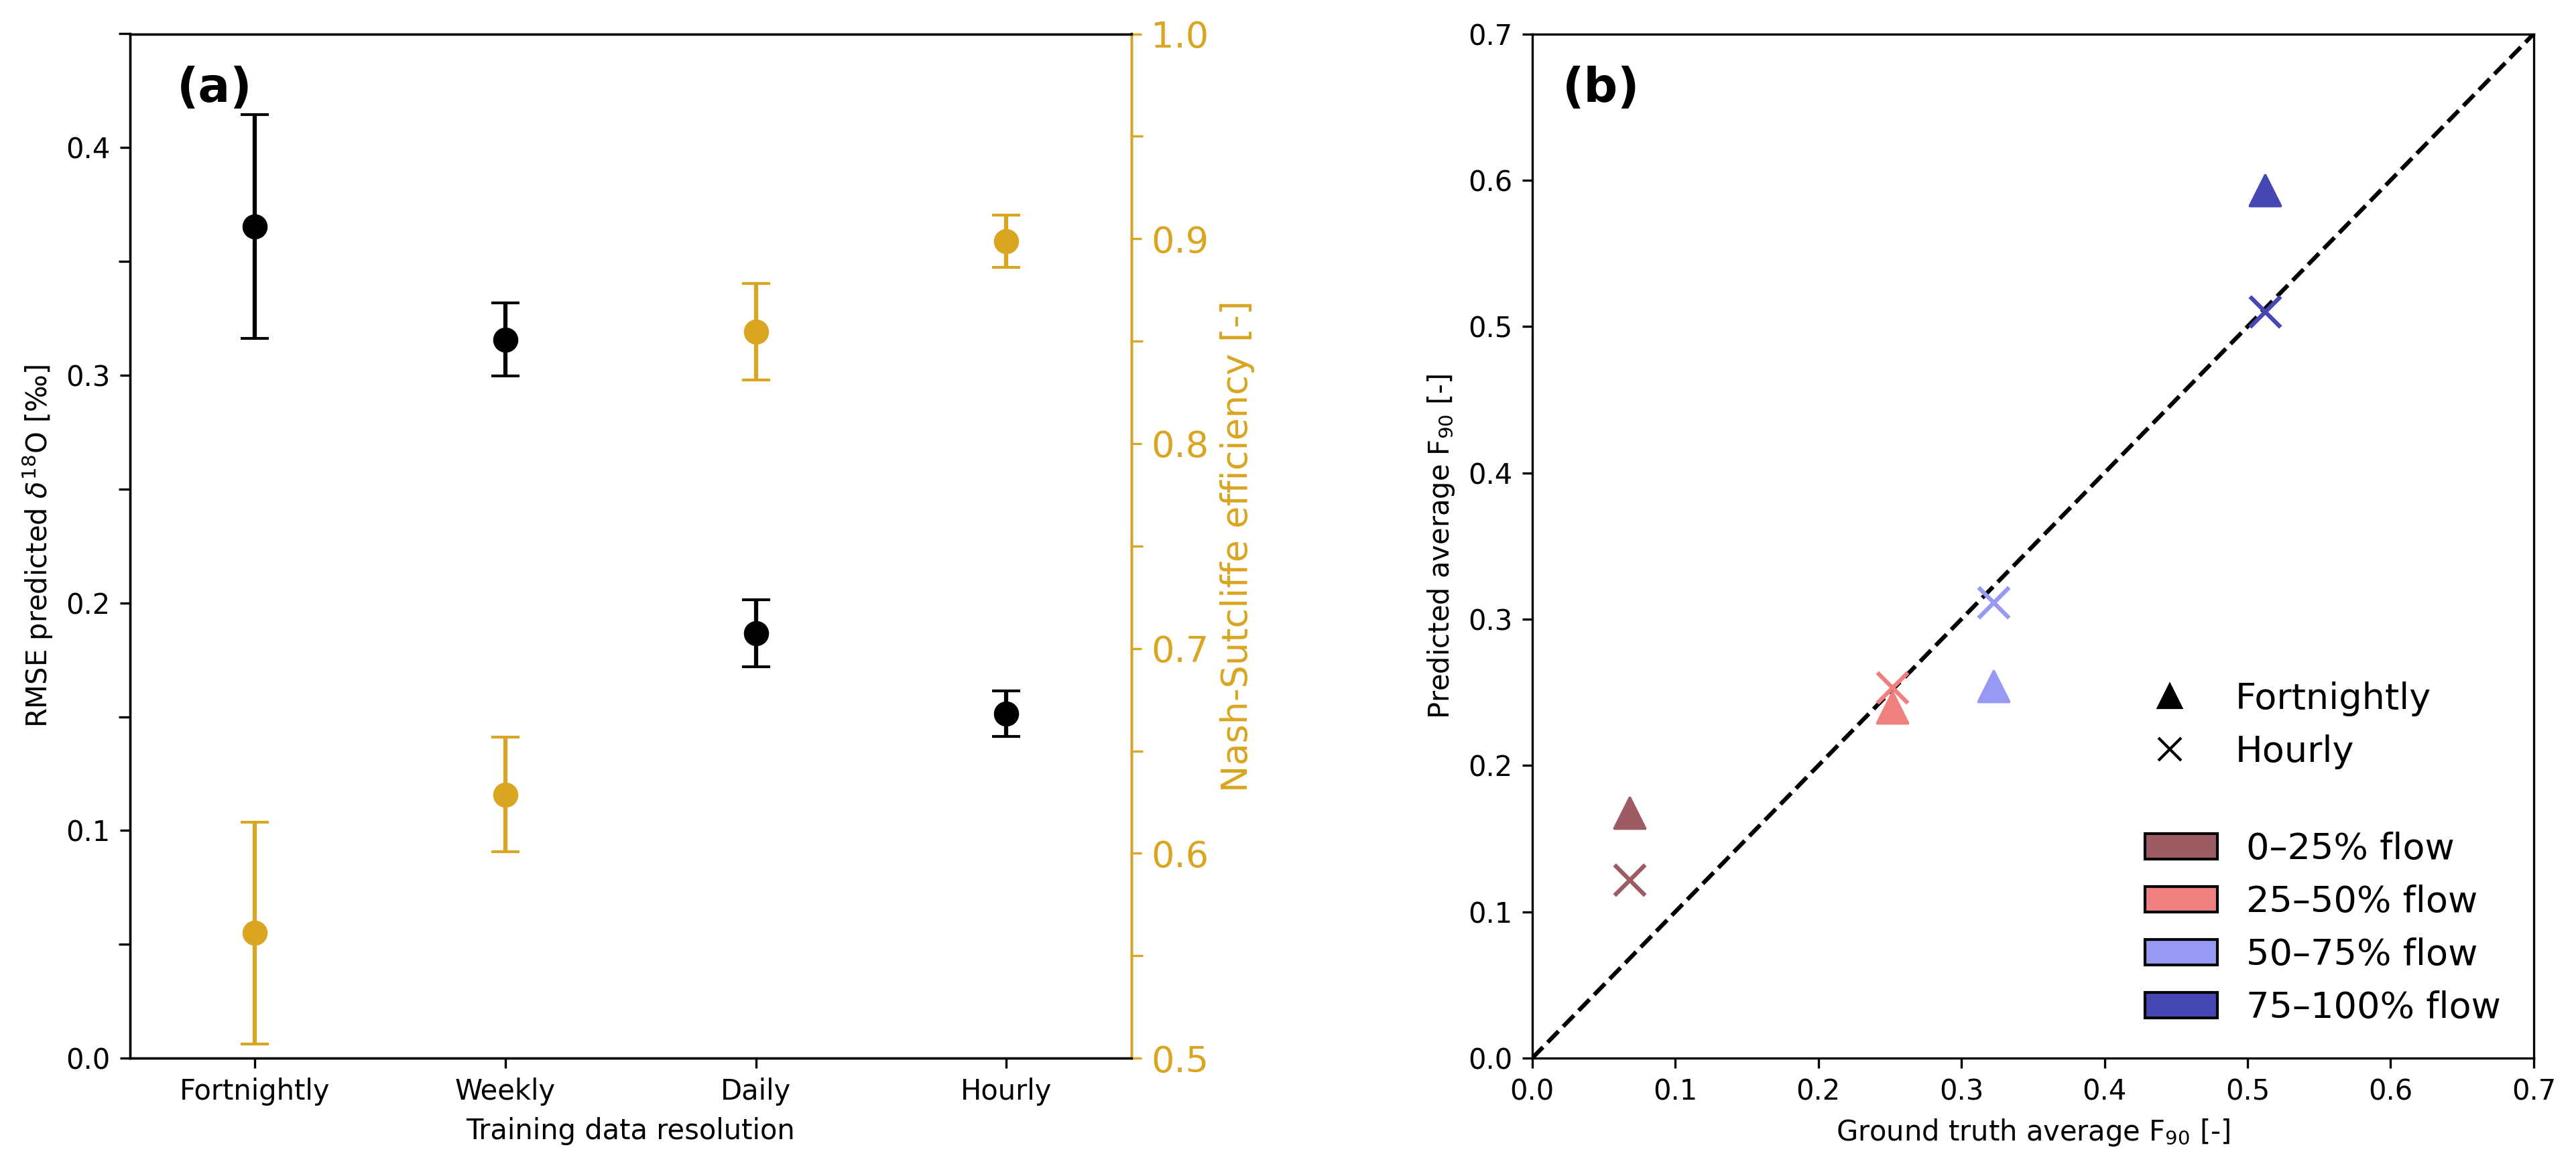

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.metrics import root_mean_squared_error
from matplotlib.ticker import MultipleLocator
# RMSE error
np.random.seed(42)
RMSE_Cout = {mode : [] for mode in mode2stride.keys()}
NSE_Cout = {mode : [] for mode in mode2stride.keys()}

ywf = {mode : {idq : [] for idq in range(4)} for mode in mode2stride.keys()}
true_ywf = {mode : {idq : [] for idq in range(4)} for mode in mode2stride.keys()}
for resolution in RMSE_Cout.keys():
    for seed in range(0,9):
        rmse = root_mean_squared_error(results['{1}_{0}'.format(seed,resolution)]['SumSquares_noBERT2_bayesian3']['Chat'],
                                       results['{1}_{0}'.format(seed,resolution)]['SumSquares_noBERT2_bayesian3']['Cout'])
        nse = compute_nse(results['{1}_{0}'.format(seed,resolution)]['SumSquares_noBERT2_bayesian3']['Chat'],
                                       results['{1}_{0}'.format(seed,resolution)]['SumSquares_noBERT2_bayesian3']['Cout'])
        RMSE_Cout[resolution].append(rmse)
        NSE_Cout[resolution].append(nse)
        for idq in range(4):
            true_ywf[resolution][idq].append(results['{1}_{0}'.format(seed,resolution)]['SumSquares_noBERT2_bayesian3']['quantile{0}_PQtrue'.format(idq)][90*24])
            ywf[resolution][idq].append(results['{1}_{0}'.format(seed,resolution)]['SumSquares_noBERT2_bayesian3']['quantile{0}_PQhat'.format(idq)][90*24])


fig, axs = plt.subplots(1, 2, figsize=(13,6), dpi=300)

font_size = 13
plt.rcParams.update({'font.size': font_size})

# First figure
markers = '.'
size_marker = 8

resolutions = [0, 1, 2, 3]

resolutions = ['2_weeks','1_week','daily','hourly']
means = [np.mean(RMSE_Cout[reso]) for reso in resolutions]
stds = [np.std(RMSE_Cout[reso]) for reso in resolutions]

axs[0].errorbar(
    resolutions, means, yerr=stds,
    fmt='o', color='k', capsize=5, markersize=size_marker
)

ax2 = axs[0].twinx()

means_NSE = [np.mean(NSE_Cout[reso]) for reso in resolutions]
stds_NSE = [np.std(NSE_Cout[reso]) for reso in resolutions]

ax2.errorbar(
    resolutions, means_NSE, yerr=stds_NSE,
    fmt='o', color='goldenrod', capsize=5, markersize=size_marker
)


# Second plot
markers = ['x', '^']
size_marker = 120
color_quantiles = ['#9D5C63', 'lightcoral', '#9799F2', '#4747B4']

axs[1].plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), c='k', linestyle='--')

for k in range(4):
    data_fictive_F90_hourly_GT = np.mean(true_ywf['hourly'][k])
    data_fictive_F90_hourly_predict = np.mean(ywf['hourly'][k])
    axs[1].scatter(data_fictive_F90_hourly_GT, data_fictive_F90_hourly_predict,
                   marker=markers[0], c=color_quantiles[k], s=size_marker, zorder=10)

for k in range(4):
    data_fictive_F90_two_weeks_GT = np.mean(true_ywf['2_weeks'][k])
    data_fictive_F90_two_weeks_predict = np.mean(ywf['2_weeks'][k])
    axs[1].scatter(data_fictive_F90_two_weeks_GT, data_fictive_F90_two_weeks_predict,
                   marker=markers[1], s=size_marker, c=color_quantiles[k], zorder=10)
    
# Esthetics
axs[0].set_xticks([0, 1, 2, 3])
axs[0].yaxis.set_major_locator(MultipleLocator(0.1))
axs[0].yaxis.set_minor_locator(MultipleLocator(0.05))
axs[0].tick_params(axis='y', which='minor', length=4, width=0.8)

axs[0].set_xticklabels(['Fortnightly', 'Weekly', 'Daily', 'Hourly'])
axs[0].set_xlim(xmin=-.5, xmax=3.5)
axs[0].set_ylim(ymin=0, ymax=.45)

axs[0].set_xlabel('Training data resolution')
axs[0].set_ylabel(r'RMSE predicted $\delta^{18}$O [‰]')

ax2.set_ylim(ymin=.5, ymax=1)

ax2.yaxis.set_major_locator(MultipleLocator(0.1))
ax2.yaxis.set_minor_locator(MultipleLocator(0.05))
ax2.tick_params(axis='y', which='minor', length=4, width=0.8, color='goldenrod')

ax2.set_ylabel('Nash-Sutcliffe efficiency [-]', color='goldenrod')
ax2.spines['right'].set_color('goldenrod')
ax2.tick_params(axis='y', colors='goldenrod')
ax2.yaxis.label.set_color('goldenrod')

axs[1].set_xlim(xmin=0, xmax=.7)
axs[1].set_ylim(ymin=0, ymax=.7)

axs[1].set_xlabel(r'Ground truth average F$_{90}$ [-]')
axs[1].set_ylabel(r'Predicted average F$_{90}$ [-]')

# Custom legend
custom_markers = [
    Line2D([0], [0], marker='^', color='black', linestyle='None', markersize=8, label='Fortnightly'),
    Line2D([0], [0], marker='x', color='black', linestyle='None', markersize=8, label='Hourly')
]

legend1 = axs[1].legend(
    handles=custom_markers,
    loc='lower right',
    bbox_to_anchor=(0.93, 0.25),
    frameon=False,
    fontsize=font_size
)

axs[1].add_artist(legend1)

color_quantiles = ['#9D5C63', 'lightcoral', '#9799F2', '#4747B4']
quantile_labels = ['0–25% flow', '25–50% flow', '50–75% flow', '75–100% flow']
quantile_patches = [
    Patch(facecolor=color, edgecolor='black', label=label)
    for color, label in zip(color_quantiles, quantile_labels)
]

axs[1].legend(
    handles=quantile_patches,
    loc='lower right',
    #bbox_to_anchor=(0, .7),  # move down slightly below the first legend
    frameon=False,
    fontsize=font_size
)

# Texts
fig.text(0.075, 0.9, '(a)', fontsize=font_size+4, weight='bold', transform=plt.gcf().transFigure)
fig.text(0.605, 0.9, '(b)', fontsize=font_size+4, weight='bold', transform=plt.gcf().transFigure)

fig.tight_layout()
fig.subplots_adjust(wspace=0.4)  # Increase spacing between subplots
plt.savefig('different_resolution.png',  bbox_inches="tight", dpi=250)

In [ ]:
site = '2_weeks'
seed='0'
pathsite = f'/mydata/watres/quentin/code/TRANSPORT/data/Pully_small_storage/subsampling/{site}/'
algo = 'WATRES'
site_name2save=site+'_noise_0.1_yearstrain_'+str(years_training)+'_'+str(seed)
x = {
    'site': f'{site}',
    'pathsite': pathsite,
    'algo': algo,
    'path_model': os.path.join(pathsite, 'save', f'save_{site_name2save}_no_c_{algo}.pth.tar'),
    'path_results': os.path.join(pathsite, 'save', f'results_{site_name2save}.pkl')
    }
model = WATRES(pathsite=x['pathsite'], site=x['site'], algo=x['algo'], path_model=x['path_model'])
def filter_dates(dates, mode='training'):
    if mode=='training':
        idxs1 = np.where(dates<=2022)[0]
        idxs2 = np.where(dates>=2020)[0]
    else:
        idxs1 = np.where(dates<=2023)[0]
        idxs2 = np.where(dates>=2022)[0]
    return np.intersect1d(idxs1, idxs2)
def filter_dates_train(dates):
    idxs = filter_dates(dates)
    return np.intersect1d(idxs, model.lst_train)

# Results of the model on the training set but on a dense grid
pred_coarse_res_train = model.model_estimate(filter_dates, BATCH_SIZE=1000)

# Results of the model exactly on the time points considered during training between 2020 and 2022
pred_coarse_scatter = model.model_estimate(filter_dates_train, BATCH_SIZE=400)

# Results of the model on the test set
pred_coarse_res_test = model.model_estimate(lambda x: filter_dates(x, mode='test'), BATCH_SIZE=1000)

In [ ]:
fig, ax = plt.subplots(figsize=(14,5), dpi=300)

timesteps_train = pred_coarse_scatter['timeyear']
idxs_train = np.where(timesteps_train>=2021)[0]
timesteps_train_plt = (timesteps_train[idxs_train].numpy() - 2021) * 365

timesteps_run_train = pred_coarse_res_train['timeyear']
idxs_run_train = np.where(timesteps_run_train>=2021)[0]
timesteps_run_train_plt = (timesteps_run_train[idxs_run_train].numpy() - 2021) * 365

timesteps_test = (pred_coarse_res_test['timeyear'].numpy() - 2022) * 365 + 365

# Ground truth
ax.plot(timesteps_run_train_plt, pred_coarse_res_train['Cout'][idxs_run_train], c='black', label='Ground truth')
ax.plot(timesteps_test, pred_coarse_res_test['Cout'], c='black')

# Coarse resolution train points
ax.scatter(timesteps_train_plt, pred_coarse_scatter['Cout'][idxs_train], s=80, edgecolors='k', facecolors='white', zorder=10, label='Training points')

# Run of the trained model over the last year of the train period
ax.plot(timesteps_run_train_plt, pred_coarse_res_train['Chat'][idxs_run_train], c='cornflowerblue', linestyle='--', label='Prediction on training data')

# Run of the trained model over the first year of the test period
ax.plot(timesteps_test, pred_coarse_res_test['Chat'], c='crimson', linestyle='--', label='Prediction on test data')

# Description
ax.vlines(x=365, ymin=-12.5, ymax=-6, linestyles='dotted', colors='k')

# Esthetics
font_size= 13

ax.set_xlabel('Time [days]')
ax.set_ylabel(r'$\delta^{18}$O [‰]', fontsize=font_size)

major_locator = MultipleLocator(100)
minor_locator = MultipleLocator(50)

ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_minor_locator(minor_locator)
ax.tick_params(axis='x', which='major', labelsize=font_size, length=6)
ax.tick_params(axis='x', which='minor', length=3)

ax.set_xlim(xmin=0, xmax=2*365)
ax.set_ylim(ymin=-12.5, ymax=-6)

ax.legend(frameon=False, loc='upper left')

ax.annotate("", xytext=(90, -12), xy=(5, -12),
            arrowprops=dict(arrowstyle="->", lw=2, color='cornflowerblue'))
ax.annotate("", xytext=(277, -12), xy=(360, -12),
            arrowprops=dict(arrowstyle="->", lw=2, color='cornflowerblue'))

ax.annotate("", xytext=(465, -12), xy=(370, -12),
            arrowprops=dict(arrowstyle="->", lw=2, color='crimson'))
ax.annotate("", xytext=(2*365-100, -12), xy=(2*365-5, -12),
            arrowprops=dict(arrowstyle="->", lw=2, color='crimson'))

fig.text(0.1825, 0.195, 'Last year of the training period', fontsize=font_size+2, color='cornflowerblue', transform=plt.gcf().transFigure)
fig.text(0.655, 0.195, 'First year of the test period', fontsize=font_size+2, color='crimson', transform=plt.gcf().transFigure)

fig.tight_layout()